In [155]:
"""
ИМПОРТЫ, ФУНКЦИИ
"""

'\nИМПОРТЫ, ФУНКЦИИ\n'

In [156]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils import ThousandLandmarksDataset

np.random.seed(1234)


In [157]:
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)


In [158]:
# фукнция наносит точки на изображение
def draw_landmarks(image, landmarks, landmarks_pred):
    for i in range(len(landmarks)):
        x, y = landmarks[i].astype(np.int)
        x_pred, y_pred = landmarks_pred[i].astype(np.int)
        cv2.circle(image, (x, y), 1, (0, 0, 255), 1, -1) # true landmark blue
        cv2.circle(image, (x_pred, y_pred), 1, (255, 0, 0), 1, -1) # pred landmark red
    return image

In [159]:
# функция считает угол между 2мя векторами построенными на 3х точках (1, 2), (2, 3)
def angle(point1: np.array, point2: np.array, point3: np.array) -> float:
    
    vector_1 = point2 - point1
    vector_2 = point3 - point2
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    return angle

In [160]:
# функция считает средний угол по всем меткам на изображении
def angle_count_on_photo(mtr: np.array) -> float:
    import math
    
    angle_lst = []
    for i in range(2, len(mtr)):
        counted_angle = angle(mtr[i-2], mtr[i-1], mtr[i]) # считаю угол
        if not(math.isnan(counted_angle)): # проверяю, что он не nan
            angle_lst.append(counted_angle)
                   
    return np.mean(angle_lst)

In [161]:
"""
СТРУКТУРА (КЛАСС) ДЛЯ ХРАНЕНИЯ ДАННЫХ
"""

'\nСТРУКТУРА (КЛАСС) ДЛЯ ХРАНЕНИЯ ДАННЫХ\n'

In [162]:
class element:
    def __init__(self, file_name: str, landmarks: np.array, landmarks_pred: np.array, mse: float = None, avg_angle: float = None):
        self.file_name = file_name
        self.landmarks = landmarks
        self.landmarks_pred = landmarks_pred
        self.mse = mse
        self.avg_angle = avg_angle
        
    def __repr__(self):
        return f"file_name={self.file_name}, mse={self.mse}, avg_angle={self.avg_angle}"
        
class data:
    def __init__(self):
        self.all_elements = []
        
    def append(self, el: element):
        self.all_elements.append(el)
        
    def sort(self, by_attribute: str, reverse: bool = False):
        self.all_elements.sort(key=lambda x: x.__dict__[by_attribute], reverse=reverse)

In [163]:
train_dataset = ThousandLandmarksDataset('data/train', '', split="train", train_size=1)
train_pred = pickle.load(open('runs/baseline/train_predictions_baseline.pkl', 'rb'))

100%|█████████▉| 64000/64001 [00:33<00:00, 1912.69it/s]


In [7]:
train_data_structure = data()

In [8]:
for i in range(len(train_dataset.image_names)):
    assert train_dataset.image_names[i] == train_pred['image_names'][i]
    
    new_element = element(
        file_name=train_dataset.image_names[i], 
        landmarks=train_dataset.landmarks.numpy()[i], 
        landmarks_pred=train_pred['landmarks'][i])
    new_element.mse = np.mean((new_element.landmarks.reshape(-1) - new_element.landmarks_pred.reshape(-1)) ** 2)
    new_element.avg_angle = angle_count_on_photo(new_element.landmarks)
    
    train_data_structure.append(new_element)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:8: RuntimeWarning: invalid value encountered in arccos
  import json
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:5: RuntimeWarning: invalid value encountered in true_divide
  # DO NOT PUT IMPORTS BEFORE THIS LINE


In [60]:
with open(os.path.join(f"runs/baseline/data.pkl"), "wb") as fp:
    pickle.dump(train_data_structure, fp)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:816: UserWarning: The following variables cannot be serialized: fp
  warnings.warn(message)


In [ ]:
"""
АНАЛИЗ ДИСПЕРСИИ УГЛА НА РАЗМЕТКЕ В ИЗОБРАЖЕНИЯХ
"""

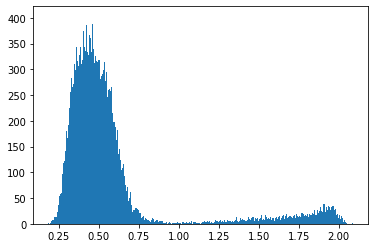

In [19]:
avg_angle = [x.avg_angle for x in train_data_structure.all_elements]
_ = plt.hist(avg_angle, bins=1000)


In [47]:
# нужно исключить все элементы, у который avg_angle > 0.85
treshold = 0.85
sum(np.array(avg_angle) > treshold)

6518

In [20]:
# Отобразим фотографии объектов с большой дисперсией угла

In [50]:
image_names = [x.file_name for x in train_data_structure.all_elements if (x.avg_angle > treshold)]
landmarks = [x.landmarks for x in train_data_structure.all_elements if (x.avg_angle > treshold)]
landmarks_pred = [x.landmarks_pred for x in train_data_structure.all_elements if (x.avg_angle > treshold)]

In [59]:
# i = 5
# random_idxs = range((i-1) * 16, i * 16)
# plt.figure(figsize=(25, NUM_ROWS * 8))
# for i, idx in enumerate(random_idxs, 1):
#     image = cv2.imread(image_names[idx])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = draw_landmarks(image, landmarks[idx], landmarks_pred[idx])
    
#     plt.subplot(NUM_ROWS, NUM_COLS, i)
#     plt.imshow(image)

# plt.tight_layout()
# plt.show()

In [58]:
bad_files_with_high_dispersion = image_names
with open(f'runs/baseline/bad_files_with_high_dispersion.txt', 'w') as f:
    f.write("\n".join(bad_files_with_high_dispersion))

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:816: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


In [ ]:
"""
АНАЛИЗ ФОТОГРАФИЙ С ВЫСОКИМ MSE (факт vs прогноз)
"""

In [61]:
mse = [x.mse for x in train_data_structure.all_elements if x.file_name not in bad_files_with_high_dispersion]

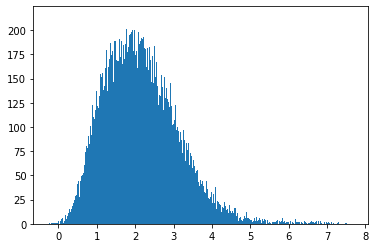

In [64]:
_ = plt.hist(np.log(mse), bins=1000)

In [65]:
# посмотрим на изображения у которых 4 <= np.log(mse) <= 5

In [128]:
threshold_low = 5
threshold_high = 100

In [129]:
# Отобразим фотографии объектов с большой mse ошибкой

In [130]:
image_names = [x.file_name for x in train_data_structure.all_elements if (x.file_name not in bad_files_with_high_dispersion) & (np.log(x.mse) > threshold_low) & (np.log(x.mse) <= threshold_high)]
landmarks = [x.landmarks for x in train_data_structure.all_elements if (x.file_name not in bad_files_with_high_dispersion) & (np.log(x.mse) > threshold_low) & (np.log(x.mse) <= threshold_high)]
landmarks_pred = [x.landmarks_pred for x in train_data_structure.all_elements if (x.file_name not in bad_files_with_high_dispersion) & (np.log(x.mse) > threshold_low) & (np.log(x.mse) <= threshold_high)]

In [131]:
len(image_names)

546

In [154]:
# i = 3
# random_idxs = range((i-1) * 16, i * 16)
# plt.figure(figsize=(25, NUM_ROWS * 8))
# for i, idx in enumerate(random_idxs, 1):
#     image = cv2.imread(image_names[idx])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = draw_landmarks(image, landmarks[idx], landmarks_pred[idx])
    
#     plt.subplot(NUM_ROWS, NUM_COLS, i)
#     plt.imshow(image)

# plt.tight_layout()
# plt.show()

In [133]:
bad_files_with_bias = image_names
with open(f'runs/baseline/bad_files_with_bias.txt', 'w') as f:
    f.write("\n".join(bad_files_with_bias))

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:816: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)
